# 04-3d-watershed.ipynb
This notebook is adapted from [00-basic-watershed-seg.ipynb](C:\Users\gusb\Research\PSAAP\share\ct-segment-python\00-basic-watershed-seg.ipynb), which was developed to be shared on the [Micromorph GitLab](https://micromorph.gitlab.io/).

Steps performed here include:
- Load subset of data (full set is >1.5 GB)
- Binarize images
- Stack images into 3D array
- Calculate local maxima
- Segment images
- Save segmented images

## Import packages

In [31]:
# Standard library imports
from pathlib import Path
# Third-party imports
import imagecodecs  # dependency required for loading compressed tif images
import imageio as iio
import matplotlib.pyplot as plt
import napari
import numpy as np
from scipy import ndimage as ndi
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util
)

## Load data

In [32]:
# Open napari viewer
viewer = napari.Viewer()

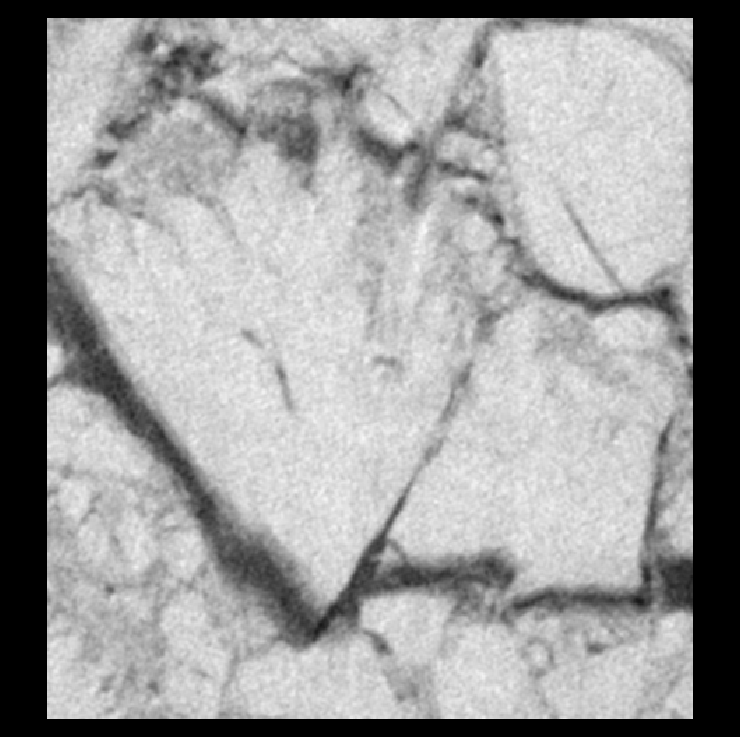

In [34]:
project_dir = Path('..')
data_dir = Path(project_dir / 'data/MOCK-IDOX_33')
img_path_list = [path for path in data_dir.glob('*.tif')]
img_path_list.sort()
data = []
for i in range(len(img_path_list)//4, 3*len(img_path_list)//4):
    img_path = img_path_list[i]
    img = iio.imread(img_path)
    img = img[
        img.shape[0]//4 : 3*img.shape[0]//4,
        img.shape[1]//4 : 3*img.shape[1]//4
    ]
    img = util.img_as_float(img)
    data.append(img)
data = np.stack(data)
data = filters.gaussian(data)
viewer.add_image(data)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Binarize data

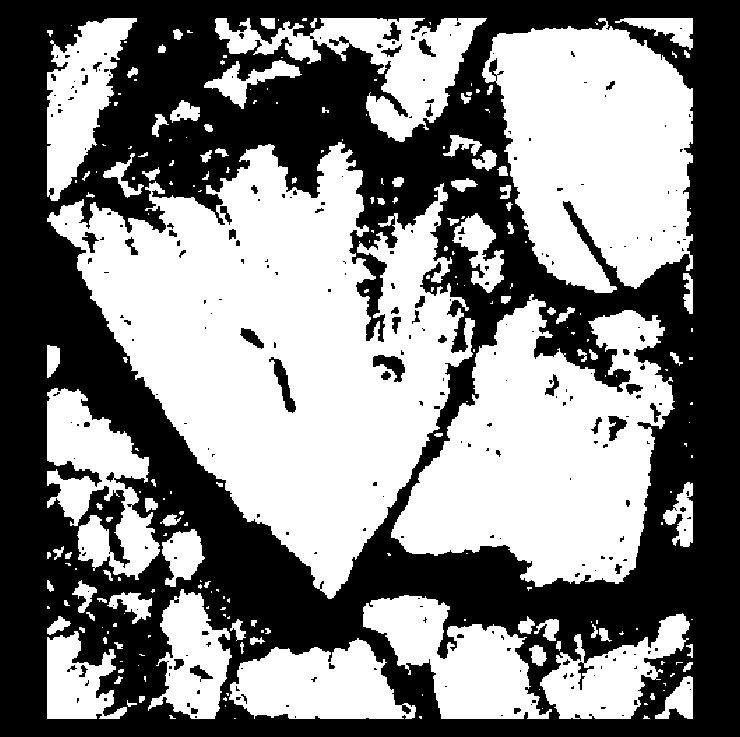

In [35]:
thresh_val = 0.65
binary = data > thresh_val
viewer.add_image(binary, name=f'thresholded: >{thresh_val}')
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Remove small holes

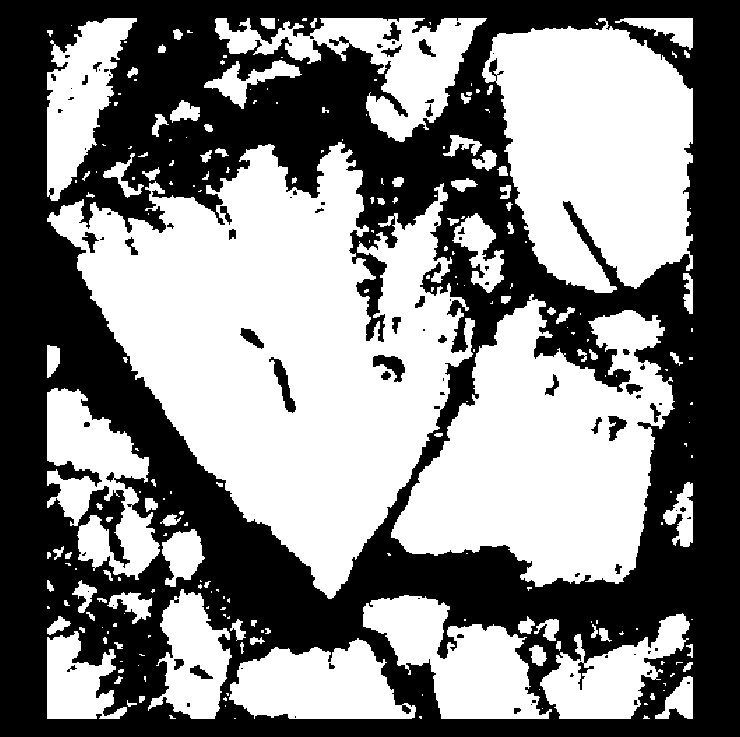

In [36]:
hole_area_threshold = 64
binary = morphology.remove_small_holes(binary, area_threshold=hole_area_threshold)
viewer.add_image(binary, name=f'remove holes: <{hole_area_threshold}')
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Create distance map

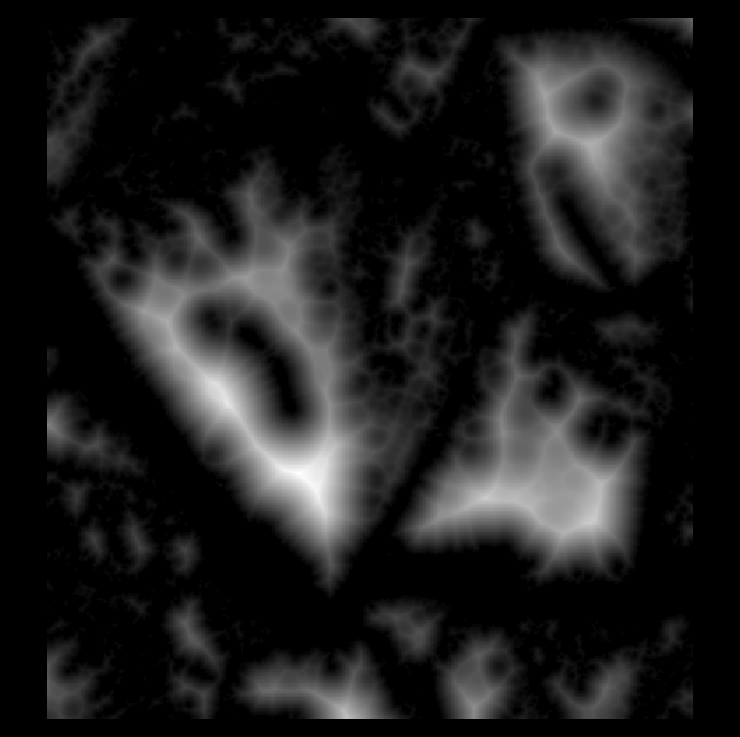

In [37]:
dist_map = ndi.distance_transform_edt(binary)
viewer.add_image(dist_map, name=f'distance map')
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Find local maxima

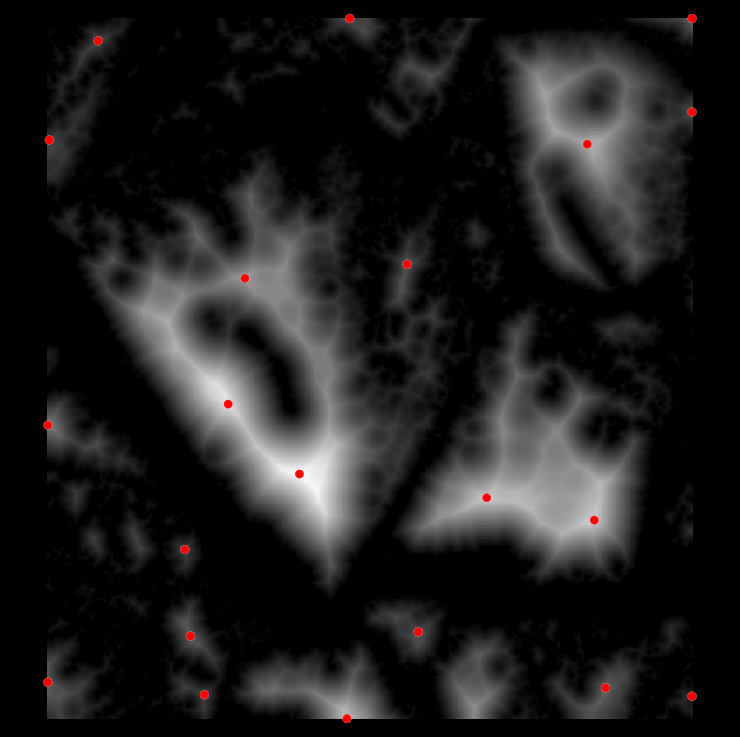

In [38]:
min_dist = 30
# Get Nx2 array of N number of (row, col) coordinates
maxima = feature.peak_local_max(
    dist_map, min_distance=min_dist, exclude_border=False
)
viewer.add_points(
    maxima, name=f'maxima: {min_dist} apart', size=5, face_color='red', 
    edge_color='transparent'
)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Seeded watershed

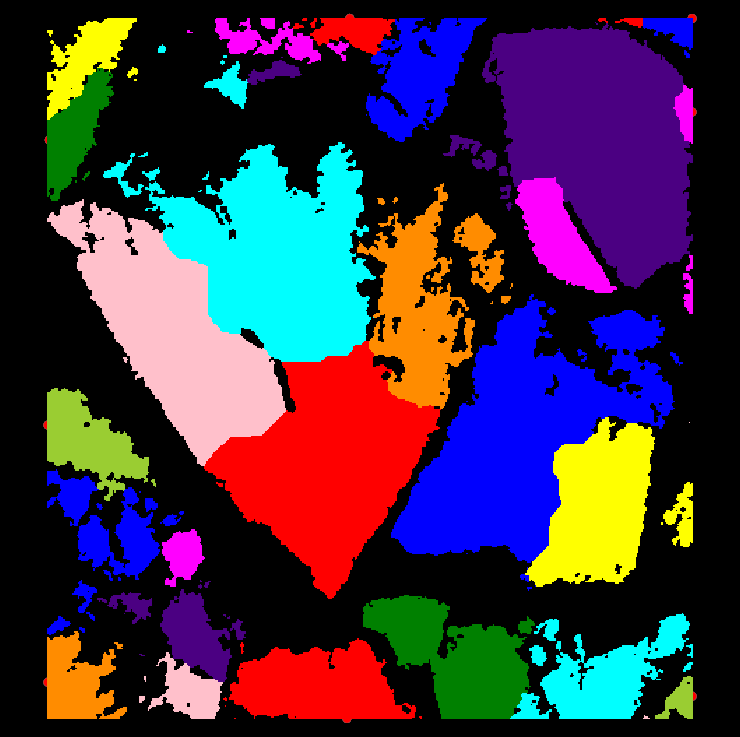

In [39]:
mask = np.zeros_like(data, dtype=bool)
mask[tuple(maxima.T)] = 1
seeds = measure.label(mask)
labels = segmentation.watershed(-dist_map, seeds, mask=binary)
labels = color.label2rgb(labels, bg_label=0)
viewer.add_image(labels, name=f'segmented')
napari.utils.nbscreenshot(viewer, canvas_only=True)